<a href="https://colab.research.google.com/github/Kryptera-K/AVB-ER-Filtered-Bollinger-Strategy-ER-BS-/blob/main/AVB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AVB"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AVB_clean.csv", index=False)
df

/tmp/ipython-input-3510998053.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,12.243702,12.356443,12.198605,12.333895,61900
2000-01-04,11.973121,12.198603,11.882928,12.176055,112300
2000-01-05,12.085861,12.085861,11.770186,11.928023,259300
2000-01-06,12.491732,12.491732,12.018218,12.040767,126500
2000-01-07,12.807404,12.987790,12.514276,12.627018,139100
...,...,...,...,...,...
2025-12-02,181.119995,181.649994,178.199997,180.149994,1048200
2025-12-03,181.520004,182.399994,180.100006,181.410004,836200
2025-12-04,179.419998,181.750000,178.860001,179.250000,1130900


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_STD = 2
ER_LEVEL_LOW = 0.3
ER_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def bb_open_above_lower(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return df['Open'] > df['BB_Lower']


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df


def er_lower_than_level(df, period=ER_PERIOD, level=ER_LEVEL_LOW):
    df = df.copy()
    df['ER'] = kaufman_efficiency_ratio(df, period=period)
    return df['ER'] < level


def kaufman_efficiency_ratio(df, period=ER_PERIOD):
    """
    Calculate Kaufman's Efficiency Ratio (ER)
    """
    df = df.copy()
    change = df['Close'].diff(period).abs()  # Absolute price change over period
    volatility = df['Close'].diff().abs().rolling(period).sum()  # Sum of absolute daily changes
    er = change / volatility
    return er



# -------------------------
# Entry conditions
# -------------------------

df["BB_Open_Above_Lower"] = bb_open_above_lower(df)

# -------------------------
# Exit conditions
# -------------------------

df["ER_Lower_Than_Level"] = er_lower_than_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BB_Open_Above_Lower',
]
exit_conditions = [
    'ER_Lower_Than_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-01-03 00:00:00
End                                   2025-12-08 00:00:00
Period                                 6523 days 00:00:00
Start Value                                      100000.0
End Value                                  2774929.704763
Total Return [%]                              2674.929705
Benchmark Return [%]                          1337.664323
Max Gross Exposure [%]                              100.0
Total Fees Paid                             145072.369861
Max Drawdown [%]                                44.829086
Max Drawdown Duration                   715 days 00:00:00
Total Trades                                           54
Total Closed Trades                                    53
Total Open Trades                                       1
Open Trade PnL                             -117576.139343
Win Rate [%]                                    58.490566
Best Trade [%]                                  82.351769
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-08 00:00:00
Period                         6523 days 00:00:00
Start Value                              100000.0
End Value                          1437664.322827
Total Return [%]                      1337.664323
Benchmark Return [%]                  1337.664323
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        69.790445
Max Drawdown Duration          1057 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1337664.322827
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-905786605.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


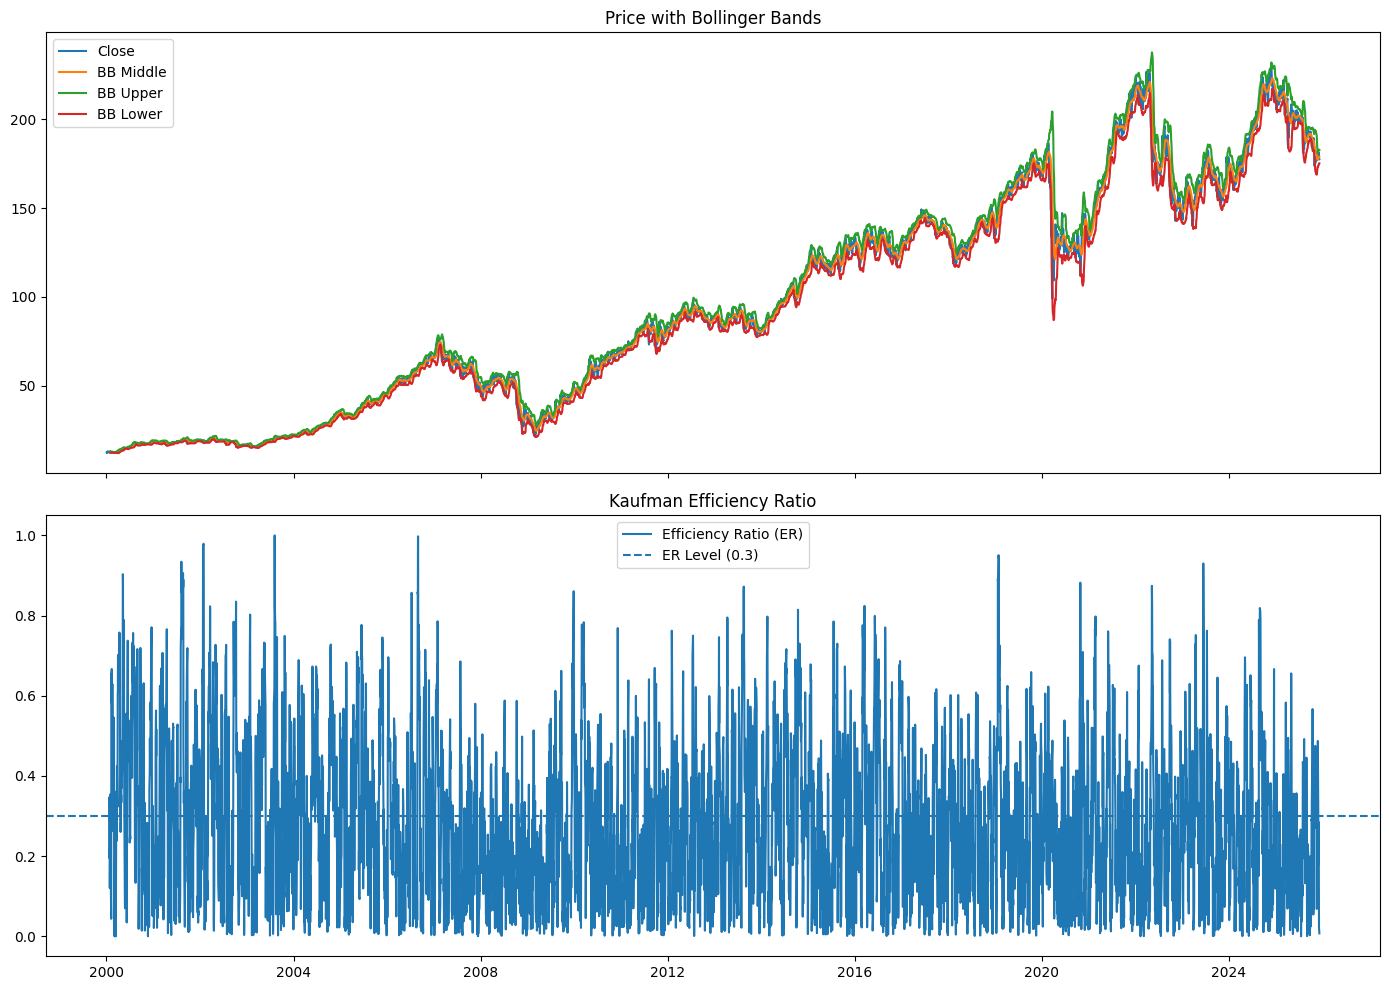

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "AVB"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_STD = 2
ER_LEVEL_LOW = 0.3
ER_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------
def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = df.copy()
    df["BB_MA"] = df["Close"].rolling(period).mean()
    df["BB_Upper"] = df["BB_MA"] + std_multiplier * df["Close"].rolling(period).std()
    df["BB_Lower"] = df["BB_MA"] - std_multiplier * df["Close"].rolling(period).std()
    return df

def kaufman_efficiency_ratio(df, period=ER_PERIOD):
    df = df.copy()
    change = df["Close"].diff(period).abs()
    volatility = df["Close"].diff().abs().rolling(period).sum()
    er = change / volatility
    return er

def bb_open_above_lower(df):
    return df["Open"] > df["BB_Lower"]

def er_lower_than_level(df):
    return df["ER"] < ER_LEVEL_LOW

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_bollinger_bands(df)

df["ER"] = kaufman_efficiency_ratio(df)
df["BB_Open_Above_Lower"] = bb_open_above_lower(df)
df["ER_Low"] = er_lower_than_level(df)

# -------------------------
# Plot
# -------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ---- Panel 1: Price + Bollinger Bands ----
axes[0].plot(df.index, df["Close"], label="Close")
axes[0].plot(df.index, df["BB_MA"], label="BB Middle")
axes[0].plot(df.index, df["BB_Upper"], label="BB Upper")
axes[0].plot(df.index, df["BB_Lower"], label="BB Lower")

axes[0].set_title("Price with Bollinger Bands")
axes[0].legend()

# ---- Panel 2: Efficiency Ratio ----
axes[1].plot(df.index, df["ER"], label="Efficiency Ratio (ER)")
axes[1].axhline(ER_LEVEL_LOW, linestyle="--", label=f"ER Level ({ER_LEVEL_LOW})")

axes[1].set_title("Kaufman Efficiency Ratio")
axes[1].legend()

plt.tight_layout()
plt.show()
